# imports

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import dask
import dask.array as da
import xarray as xr

#import toolbox_scs as tb
#from toolbox_scs.routines.boz import load_dssc_module
from extra_data import open_run
from itertools import combinations
from itertools import repeat
from dask.distributed import Client, progress, performance_report, get_task_stream
from dask_jobqueue import SLURMCluster

import pandas as pd
from datetime import date
from tqdm.notebook import tqdm
import matplotlib as mpl
plt.style.use('./zoey_style.mplstyle')

from os.path import basename, exists

from glob import glob
from pathlib import Path
from lmfit import Model, Parameters
from scipy.special import gamma, factorial, loggamma
from matplotlib.colors import LogNorm
from time import time
from numba import njit

## metadata

In [2]:
current =    [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
runNB =      [70,  71,  73,  74,  76,  77,  79,  80,  82]
modules = [15, 0, 8, 7]
proposalNB = 2884

field = current[0]
run = runNB[0]
module = modules[1]
phi_index = 2
group = 10

# load in photon maps

In [3]:
photon_maps = np.load(f'/gpfs/exfel/u/scratch/SCS/202201/p002884/LS/Reduced_Data/reduced_3-17-23/r{run:0d}m{module:0d}_{group:1d}_photon.npy', 'r')[:10]

In [4]:
photon_maps.shape

(10, 200, 128, 512)

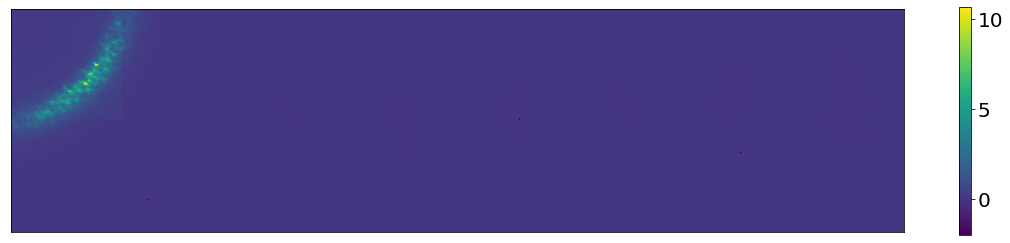

In [10]:
plt.figure(figsize=(20,6))
plt.imshow(photon_maps.mean(axis=(0,1)))
plt.colorbar(shrink=0.7)
plt.xticks([])
plt.yticks([])
plt.show()

# check mask

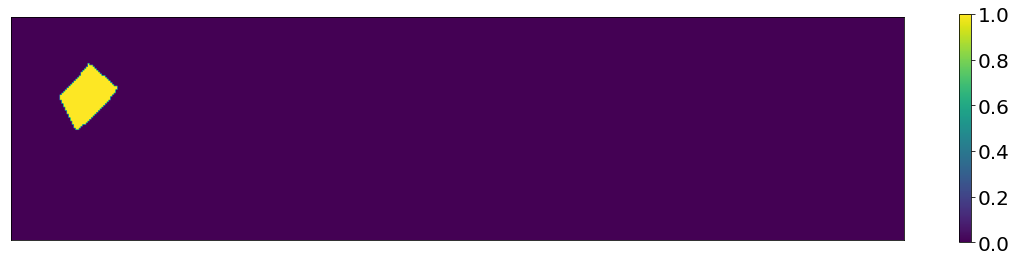

In [6]:
mask = np.load(f'./masks/run{run:0d}_module{module:1d}_mask.npy')
mask[mask!=phi_index] = 0
mask[mask==phi_index] = 1
mask = mask.astype(bool)

plt.figure(figsize=(20,6))
plt.imshow(mask)
plt.colorbar(shrink=0.7)
plt.xticks([])
plt.yticks([])
plt.show()

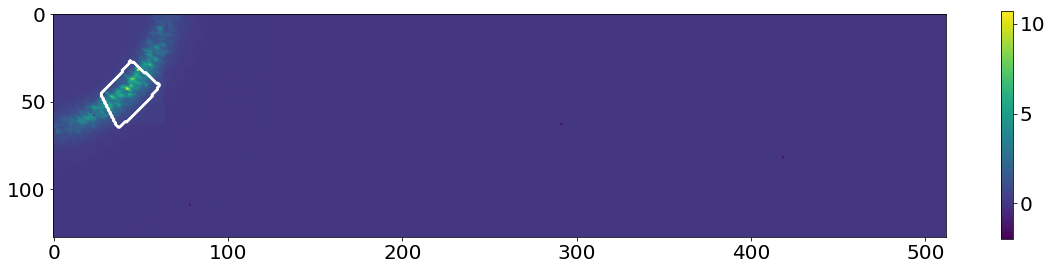

In [7]:
plt.figure(figsize=(20,6))
plt.imshow(photon_maps.mean(axis=(0,1)))
plt.colorbar(shrink=0.7)
plt.contour(mask, colors=['w'])
plt.xticks([])
plt.yticks([])
plt.show()

# truncate data around ROI

In [8]:
locs = np.argwhere(mask==1).T
small_roi = np.s_[min(locs[0]):max(locs[0]), min(locs[1]):max(locs[1])]

small_mask = mask[small_roi]
pm = photon_maps[(..., *small_roi)]

In [9]:
pm.shape

(10, 200, 37, 32)

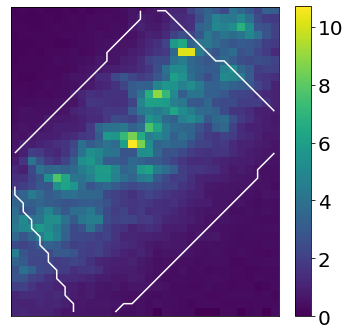

In [10]:
plt.figure(figsize=(6,6))
plt.imshow(pm.mean(axis=(0,1)))
plt.colorbar(shrink=0.95)
plt.contour(small_mask, colors=['w'], levels=0)
plt.xticks([])
plt.yticks([])
plt.show()

In [11]:
train = np.ma.masked_array(data=np.maximum(0, pm[0]), mask=np.broadcast_to(small_mask, pm[0].shape))
train = train.compressed().reshape(train.shape[0], -1)
pm[0].shape, train.shape

((200, 37, 32), (200, 530))

# check integrated intensity to filter

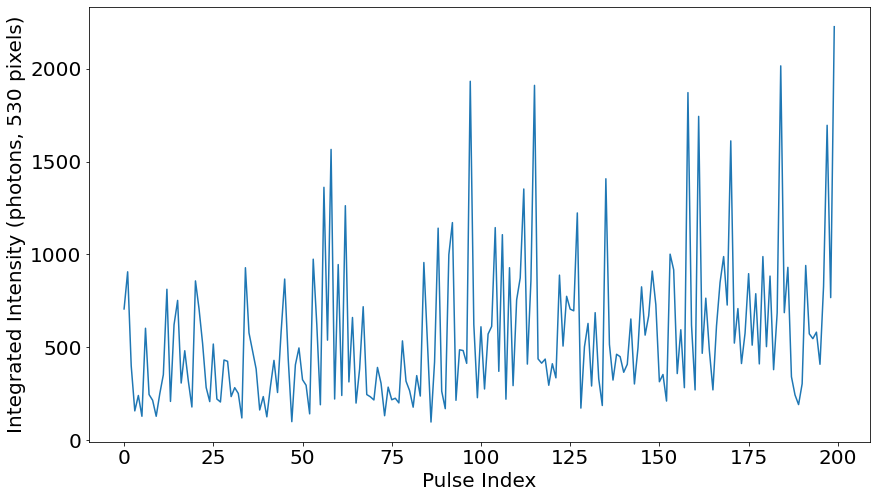

In [12]:
intensities = train.sum(axis=1)
plt.figure()
plt.plot(intensities)
plt.xlabel('Pulse Index')
plt.ylabel(f'Integrated Intensity (photons, {train.shape[-1]:.0f} pixels)')
plt.show()

# separate into two stacks to add with certain delay time

In [23]:
pulse_tol = 0.05
dt = 10
left_stack = train[:len(train)-dt]
right_stack = train[dt:]

left_stack.shape, right_stack.shape

((190, 530), (190, 530))

# filter data by integrated intensity

In [24]:
left_sum = np.sum(left_stack, axis=-1)
right_sum = np.sum(right_stack, axis=-1)
filt = np.logical_and(left_sum<=(1+pulse_tol)*right_sum, 
                      right_sum<=(1+pulse_tol)*left_sum)

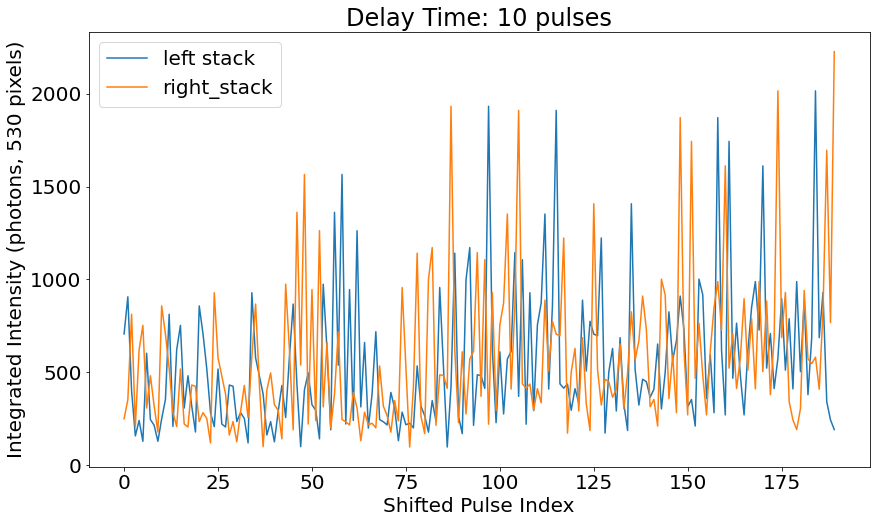

In [25]:
plt.figure()
plt.title(f'Delay Time: {dt} pulses')
plt.plot(left_sum, label='left stack')
plt.plot(right_sum, label='right_stack')
plt.xlabel('Shifted Pulse Index')
plt.ylabel(f'Integrated Intensity (photons, {train.shape[-1]:.0f} pixels)')
plt.legend()
plt.show()

# check number of valid pulses

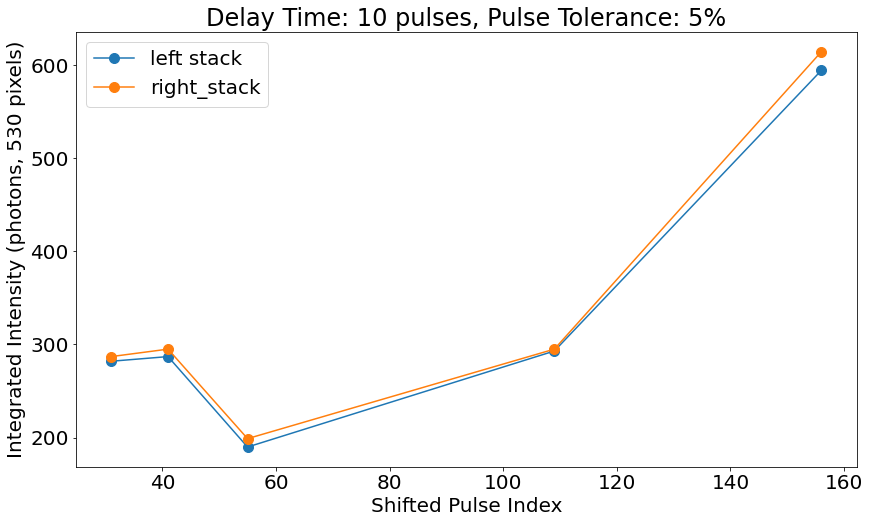

Total Number of Valid Pulses: 5


In [26]:
plt.figure()
plt.title(f'Delay Time: {dt} pulses, Pulse Tolerance: {pulse_tol*100:.0f}%')
plt.plot(np.where(filt)[0], left_sum[filt], '-o', label='left stack')
plt.plot(np.where(filt)[0], right_sum[filt], '-o', label='right_stack')
plt.xlabel('Shifted Pulse Index')
plt.ylabel(f'Integrated Intensity (photons, {train.shape[-1]:.0f} pixels)')
plt.legend()
plt.show()
print('Total Number of Valid Pulses:', len(np.where(filt)[0]))

In [27]:
valid_pulses = []
for i in tqdm(range(len(train)), total=len(train)):
    left_stack = train[:len(train)-i]
    right_stack = train[i:]
    
    left_sum = np.sum(left_stack, axis=-1)
    right_sum = np.sum(right_stack, axis=-1)
    filt = np.logical_and(left_sum<=(1+pulse_tol)*right_sum, 
                          right_sum<=(1+pulse_tol)*left_sum)
    
    # only keep one example pulse. for purposes of this notebook only
    if i == dt:
        two_images = left_stack[filt] + right_stack[filt]
    
    valid_pulses.append(len(np.where(filt)[0]))
valid_pulses = np.array(valid_pulses)

  0%|          | 0/200 [00:00<?, ?it/s]

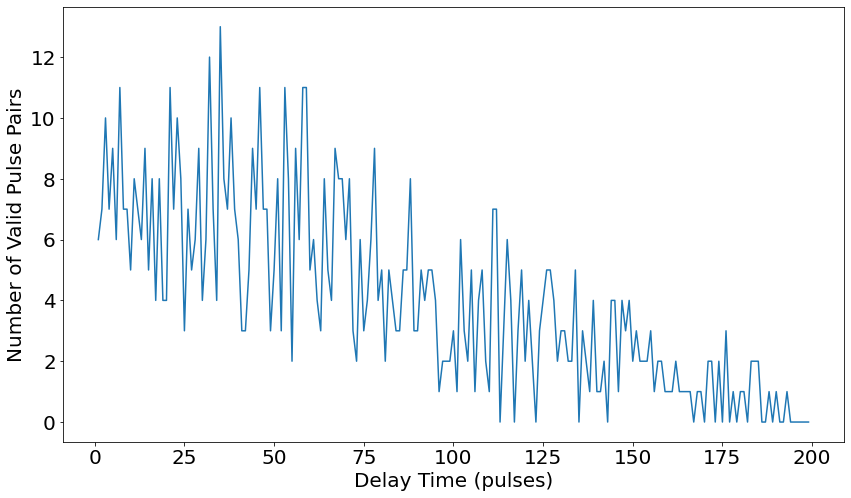

In [28]:
plt.figure()
plt.plot(np.arange(1, len(valid_pulses)), valid_pulses[1:])
plt.xlabel('Delay Time (pulses)')
plt.ylabel('Number of Valid Pulse Pairs')
plt.show()

# calculate probability of photon arrival

In [29]:
prob_k = np.zeros((50, len(two_images)))
two_images[two_images>50] = 50
for ii, p in enumerate(two_images.astype(int)):
    counts = np.bincount(p)
    prob_k[:len(counts), ii] = counts / (len(p))
    
avg_k = np.mean(two_images, axis=(-1))
prob_k.shape, avg_k.shape

((50, 5), (5,))

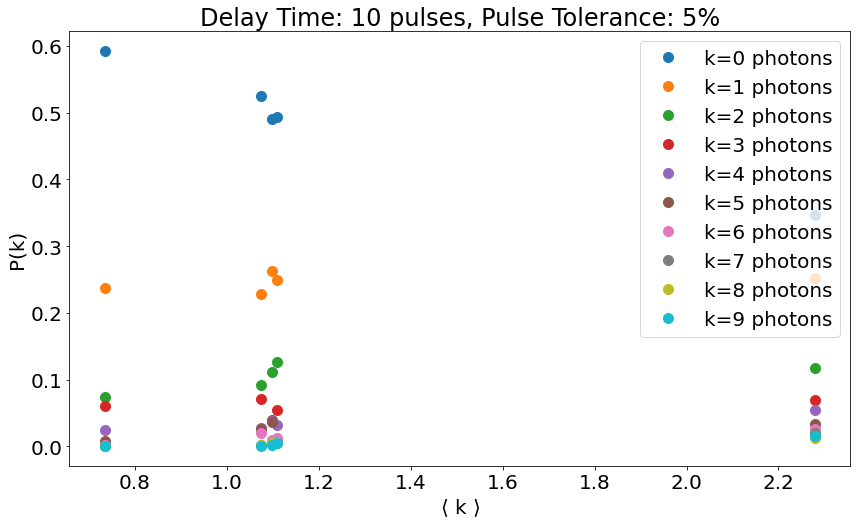

In [30]:
plt.figure()
plt.plot(avg_k, prob_k[:10].T,'o', label=[f'k={k_} photons' for k_ in np.arange(10)])
plt.xlabel(r'$\langle$ k $\rangle$')
plt.ylabel('P(k)')
plt.legend(loc='upper right')
plt.title(f'Delay Time: {dt} pulses, Pulse Tolerance: {pulse_tol*100:.0f}%')
plt.show()

In [31]:
prob_k.shape, avg_k.shape, valid_pulses.shape, intensities.shape

((50, 5), (5,), (200,), (200,))

# loop

In [32]:
pwd

'/gpfs/exfel/u/usr/SCS/202201/p002884/Software/zoey/EuXFEL'

In [34]:
def stash_average_photon_map(base_path, average_photon_map, mask):
    # save average image
    out_path = base_path + 'average.npy'
    np.save(out_path, average_photon_map)

     # save figure of average image
    out_path = base_path + '/images/average_image.png'
    plt.figure(figsize=(20,6))
    plt.imshow(average_photon_map)
    plt.colorbar(shrink=0.7)
    plt.xticks([])
    plt.yticks([])
    plt.savefig(out_path)
    plt.close()

    # save figure of mask
    out_path = base_path + '/images/mask.png'
    plt.figure(figsize=(20,6))
    plt.imshow(mask)
    plt.colorbar(shrink=0.7)
    plt.xticks([])
    plt.yticks([])
    plt.savefig(out_path)
    plt.close()

    # save figure of mask contour around average image
    out_path = base_path + '/images/mask_contour.png'
    plt.figure(figsize=(20,6))
    plt.imshow(average_photon_map)
    plt.colorbar(shrink=0.7)
    plt.contour(mask, colors=['w'])
    plt.xticks([])
    plt.yticks([])
    plt.savefig(out_path)
    plt.close()
    return
    
def stash_small_average_photon_map(base_path, small_average_photon_map, small_mask, phi_index):    
    # save figure of small data (bounding box around ROI) and mask contour
    out_path = base_path + f'/images/small_mask_contour_phi{phi_index}.png'
    plt.figure(figsize=(6,6))
    plt.imshow(small_average_photon_map)
    plt.colorbar(shrink=0.95)
    plt.contour(small_mask, colors=['w'], levels=0)
    plt.xticks([])
    plt.yticks([])
    plt.savefig(out_path)
    plt.close()
    return

In [49]:
# metadata
current =    [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
runNB =      [70,  71,  73,  74,  76,  77,  79,  80,  82]
modules = [15, 0, 8, 7]
proposalNB = 2884

field = current[0]
run = runNB[0]
module = modules[1]
phi_index = 2
group = 10

# setup directories to check intermediate values (for debugging purposes)
base_path = f'./stashes/debug/run{run:0d}_module{module:0d}_group{group:1d}/'
Path(base_path).mkdir(parents=True, exist_ok=True)
Path(base_path + '/images').mkdir(parents=True, exist_ok=True)

# load in mask and determine bounding box (ROI)
mask = np.load(f'./masks/run{run:0d}_module{module:1d}_mask.npy')
mask[mask!=phi_index] = 0
mask[mask==phi_index] = 1
mask = mask.astype(bool)
locs = np.argwhere(mask==1).T
small_roi = np.s_[min(locs[0]):max(locs[0]), min(locs[1]):max(locs[1])]

# load photon maps. if the average photon map is not saved yet then load 
# in the entire dataset. otherwise only load in a small subset of data
# around current phi index
photon_maps_filename = f'/gpfs/exfel/u/scratch/SCS/202201/p002884/LS/Reduced_Data/reduced_3-17-23/r{run:0d}m{module:0d}_{group:1d}_photon.npy'
average_photon_map_path = base_path + 'average.npy'
small_average_photon_map_path = base_path + f'/images/small_mask_contour_phi{phi_index}.png'
if not exists(average_photon_map_path):
    # load in photon maps and calculate average
    photon_maps = np.load(photon_maps_filename, 'r')
    avg_img = photon_maps.mean(axis=(0,1))
    
    # save intermediate data
    stash_average_photon_map(base_path=base_path, average_photon_map=avg_img, mask=mask)
if not exists(small_average_photon_map_path):
    photon_maps = np.load(photon_maps_filename, 'r')[(..., *small_roi)]
    avg_img = photon_maps.mean(axis=(0,1))
    # save intermediate data (small roi)
    stash_small_average_photon_map(base_path=base_path, small_average_photon_map=avg_img, small_mask=mask[small_roi], phi_index=phi_index)
    
    
# photon_maps shape is (N trains x 200 pulses X rows x cols).
photon_maps = np.load(photon_maps_filename, 'r')[(..., *small_roi)]
for train_id, pm in enumerate(photon_maps):
    # turn train into masked array to remove unwanted pixels
    train = np.ma.masked_array(data=np.maximum(0, pm), mask=np.broadcast_to(small_mask, pm.shape))
    # ravel pixels and remove masked values. train shape is (200 pulses x N pixels)
    train = train.compressed().reshape(train.shape[0], -1)

    # integrated intensity of image within train intensities shape is (200 pulses)
    intensities = train.sum(axis=1)
    
    # iterate over all delay times between two pulses (dt = 0 ... dt = 199)
    # check how many pulses pass the intensity filter
    valid_pulses = np.zeros(len(train))
    # prob_k_all shape is (delay time [200 max] x K [50 max] photons arriving x N [200 max] valid pulses)
    prob_k_all = np.zeros((200, 50, 200)) * np.nan
    # avg_k_all shape is (delay time [200 max] x N [200 max] valid pulses)
    avg_k_all = np.zeros((200, 200)) * np.nan
    for i, dt in tqdm(enumerate(range(len(train))), total=len(train)):
        left_stack = train[:len(train)-dt]
        right_stack = train[dt:]
        left_sum = np.sum(left_stack, axis=-1)
        right_sum = np.sum(right_stack, axis=-1)
        filt = np.logical_and(left_sum<=(1+pulse_tol)*right_sum, 
                              right_sum<=(1+pulse_tol)*left_sum)
        
        valid_pulses[i] = len(np.where(filt)[0])
        # integrate two single pulses to calculate contrast. two_images shape is (N valid pulses x M pixels)
        two_images = left_stack[filt] + right_stack[filt]                      
        # if there are pixels above 49 photons then set it to 49. This value won't be used in calculating the
        # contrast and ensures a consistent size when using np.bincount below
        two_images[two_images>49] = 49
                            
        # enumerate over all valid pulses to extract the probability of photon arrival events.
        prob_k = np.zeros((50, 200)) * np.nan
        avg_k = np.zeros((50, 200)) * np.nan
        for ii, p in enumerate(two_images.astype(int)):
            counts = np.bincount(p)
            prob_k[:len(counts), ii] = counts / (len(p))
    
        avg_k = np.mean(two_images, axis=(-1))
        
        prob_k_all[i] = prob_k
        avg_k_all[i, :len(avg_k)] = avg_k
        
    # store all relevant data for a single train in a consistent data structure
    ds_iter = xr.Dataset(
        data_vars={'probability_k_photons': (('pulse_separation', 'k_photons', 'unique_pairs'), prob_k_all),
                  'average_number_photons': (('pulse_separation', 'unique_pairs'), avg_k_all),
                  'number_valid_pairs': (('index'), valid_pulses),
                   'integrated_intensity': (('pulse_index'), intensities),
                   'train_index': train_id,
                   'group_index': group,
                   'phi_index': phi_index
                  },
        attrs={'run_number': run,
               'magnet_current': field,
               'module_number': module,
               'intensity_pulse_tolerance': pulse_tol,
              }
    )    
    # only do one photon map to check that everything is working
    break

  0%|          | 0/200 [00:00<?, ?it/s]

In [48]:
ds_iter

<xarray.Dataset>
Dimensions:                 (pulse_separation: 200, k_photons: 50, unique_pairs: 200, index: 200, pulse_index: 200)
Dimensions without coordinates: pulse_separation, k_photons, unique_pairs, index, pulse_index
Data variables:
    probability_k_photons   (pulse_separation, k_photons, unique_pairs) float64 ...
    average_number_photons  (pulse_separation, unique_pairs) float64 2.664 .....
    number_valid_pairs      (index) float64 200.0 6.0 7.0 10.0 ... 0.0 0.0 0.0
    integrated_intensity    (pulse_index) float64 706.0 906.0 ... 2.226e+03
    train_index             int64 0
    group_index             int64 10
    phi_index               int64 2
Attributes:
    run_number:      70
    magnet_current:  0.0
    module_number:   0

In [50]:
# test concatenating xarrays
out = [ds_iter, ds_iter]
ds = xr.concat(out, dim='train_index')

In [51]:
ds

<xarray.Dataset>
Dimensions:                 (train_index: 2, pulse_separation: 200, k_photons: 50, unique_pairs: 200, index: 200, pulse_index: 200)
Coordinates:
  * train_index             (train_index) int64 0 0
Dimensions without coordinates: pulse_separation, k_photons, unique_pairs, index, pulse_index
Data variables:
    probability_k_photons   (train_index, pulse_separation, k_photons, unique_pairs) float64 ...
    average_number_photons  (train_index, pulse_separation, unique_pairs) float64 ...
    number_valid_pairs      (train_index, index) float64 200.0 6.0 ... 0.0 0.0
    integrated_intensity    (train_index, pulse_index) float64 706.0 ... 2.22...
    group_index             (train_index) int64 10 10
    phi_index               (train_index) int64 2 2
Attributes:
    run_number:      70
    magnet_current:  0.0
    module_number:   0

# new structure

# parallel ROI

In [3]:
partition = 'upex'   # For users

cluster = SLURMCluster(
    queue=partition,
    local_directory='/scratch',  # Local disk space for workers to use
    log_directory='./logs',
    walltime=1800,

    # Resources per SLURM job (per node, the way SLURM is configured on Maxwell)
    # processes=16 runs 16 Dask workers in a job, so each worker has 1 core & 32 GB RAM.
    processes=16, cores=16, memory='512GB',
)

# Get a notbook widget showing the cluster state
cluster

In [4]:
cluster.scale(16)

In [5]:
client = Client(cluster)
client

<Client: 'tcp://131.169.183.134:45303' processes=16 threads=16, memory=476.80 GiB>

In [6]:
ds = xr.open_dataset('./labels.h5')
ds

<xarray.Dataset> Size: 6MB
Dimensions:     (module: 4, row: 128, col: 512)
Dimensions without coordinates: module, row, col
Data variables:
    angle_grid  (module, row, col) float64 2MB ...
    labels      (module, row, col) float64 2MB ...
    q_grid      (module, row, col) float64 2MB ...
Attributes:
    run_number:      70
    magnet_current:  0.0
    module_order:    [15  0  8  7]
    date_processed:  08/23/2024, 19:12:28

In [130]:
def load_photon_maps_dask(run, module, group, train_index):
    photon_maps_filename = f'/gpfs/exfel/u/scratch/SCS/202201/p002884/LS/Reduced_Data/reduced_3-17-23/r{run:0d}m{module:0d}_{group:1d}_photon.npy'
    photon_maps = np.load(photon_maps_filename, 'r')[train_index]
    return da.from_array(photon_maps)

photon_maps = load_photon_maps_dask(run, module, group, np.s_[:10])
photon_maps

dask.array<array, shape=(10, 200, 128, 512), dtype=float64, chunksize=(10, 118, 118, 118), chunktype=numpy.ndarray>

In [ ]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

In [24]:
train = photon_maps[0]
pm = photon_maps[:10].mean(axis=(0,1)).compute()

In [25]:
train

dask.array<getitem, shape=(200, 128, 512), dtype=float64, chunksize=(118, 118, 118), chunktype=numpy.ndarray>

In [26]:
train = train.reshape((len(train),-1)).astype(np.int32)
train

dask.array<astype, shape=(200, 65536), dtype=int32, chunksize=(118, 13312), chunktype=numpy.ndarray>

In [27]:
def load_labels(module, q_cutoff=15, return_unique_labels=True):
    ds = xr.open_dataset('./labels.h5')
    q = np.squeeze(ds['q_grid'][ds.module_order==module].to_numpy())
    labels = np.squeeze(ds['labels'][ds.module_order==module].to_numpy())
    labels[q>q_cutoff] = np.nan
    
    if return_unique_labels:
        unique_labels = np.unique(labels)
        unique_labels = unique_labels[~np.isnan(unique_labels)] 
        return da.from_array(labels), unique_labels
    else:
        return da.from_array(labels)

labels, unique_labels = load_labels(module)

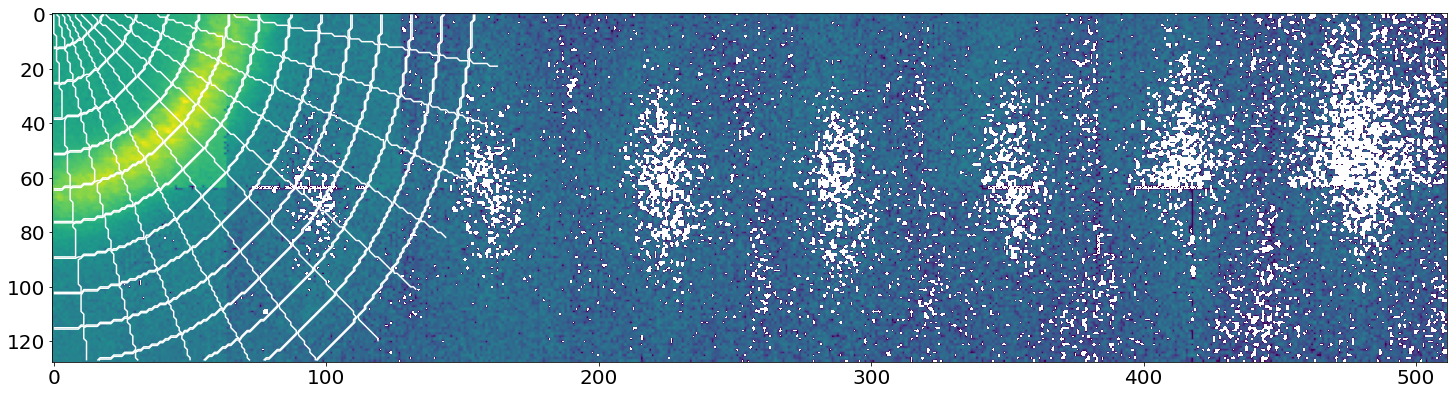

In [28]:
plt.figure(figsize=(25,10))
plt.imshow(pm, norm=LogNorm())
plt.contour(labels, levels=len(unique_labels), colors=['w'])
plt.show()

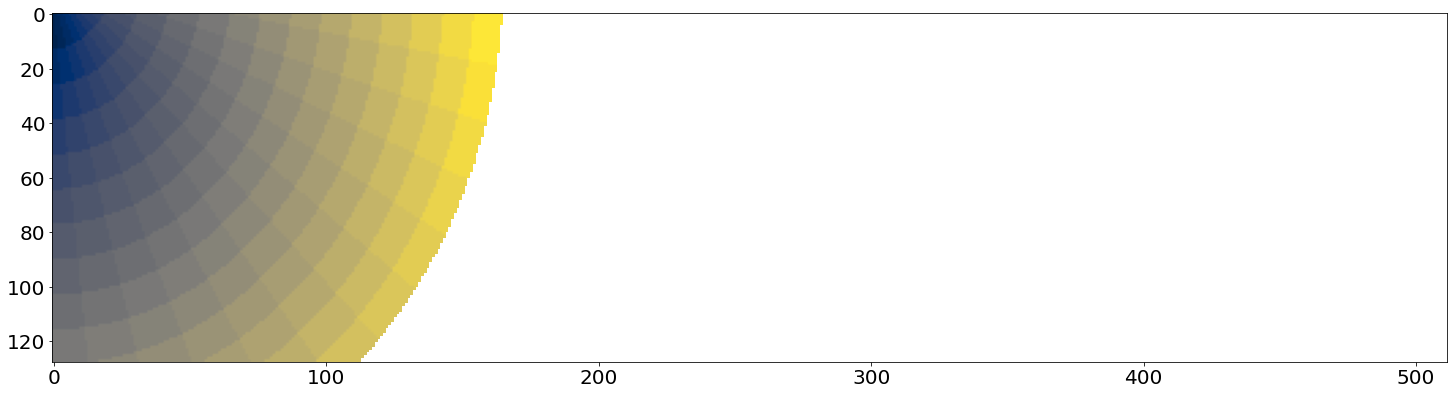

In [29]:
plt.figure(figsize=(25,10))
plt.imshow(labels, cmap='cividis')
plt.show()

Option A: Iterate over all ROIs

Option B: Keep track of indices and filter later


In [30]:
intensity = train.mean(axis=(1)).compute()
intensity.shape

(200,)

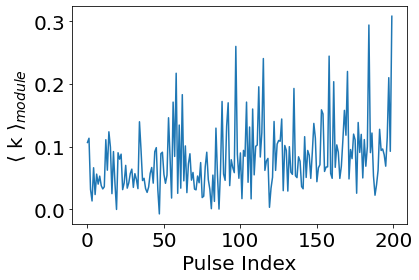

In [31]:
plt.figure()
plt.plot(intensity)
plt.xlabel('Pulse Index')
plt.ylabel(r'$\langle$ k $\rangle_{module}$')
plt.show()

In [32]:
def calculate_intensity_filter(intensity, pulse_tolerance=0.05):
    """Calculate mask for pulse delays to be excluded. Returned array is upper diagonal."""
    filt = np.full((len(intensity), len(intensity)), False)

    for i in range(len(intensity)):
        left = intensity[:(len(intensity)-i)]
        right = intensity[i:]
        num = abs(left - right)
        denom = abs(left + right)
        filt[i, :len(left)] = (num / denom) < pulse_tolerance
    return filt

In [33]:
filt = calculate_intensity_filter(intensity)

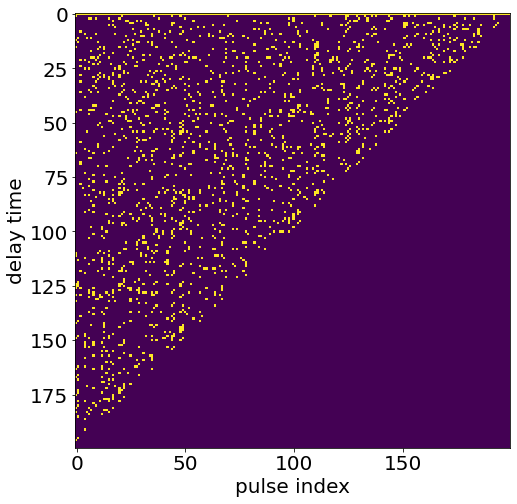

In [34]:
plt.figure(figsize=(8,8))
plt.imshow(filt, interpolation='none')
plt.ylabel('delay time')
plt.xlabel('pulse index')
plt.show()

In [9]:
def load_labels(module, q_cutoff=15, return_unique_labels=True):
    ds = xr.open_dataset('./labels.h5')
    q = np.squeeze(ds['q_grid'][ds.module_order==module].to_numpy())
    labels = np.squeeze(ds['labels'][ds.module_order==module].to_numpy())
    labels[q>q_cutoff] = np.nan
    
    if return_unique_labels:
        unique_labels = np.unique(labels)
        unique_labels = unique_labels[~np.isnan(unique_labels)] 
        return da.from_array(labels), unique_labels
    else:
        return da.from_array(labels)
    
def add_two_stacks(train, delay, filt, min_photons=0, max_photons=19):
    left_stack = train[:len(train)-delay][filt]
    right_stack = train[delay:][filt]
    two_sum = (left_stack + right_stack)[0]
    two_sum = np.maximum(min_photons, two_sum)
    two_sum = np.minimum(max_photons, two_sum)
    return two_sum

def calculate_probabilities_within_label(image, labels, unique_label, max_photons):
    masked_image = image[np.broadcast_to((labels==unique_label).ravel(), image.shape)]
    probabilities = np.bincount(masked_image, minlength=max_photons+1) / image.shape[-1]
    return probabilities


def calculate_intensity_filter(train, pulse_tolerance=0.05):
    """Calculate mask for pulse delays to be excluded. Returned array is upper diagonal."""
    intensity = train.mean(axis=(1)).compute()
    filt = np.full((len(intensity), len(intensity)), False)
    for i in range(len(intensity)):
        left = intensity[:(len(intensity)-i)]
        right = intensity[i:]
        num = abs(left - right)
        denom = abs(left + right)
        filt[i, :len(left)] = (num / denom) < pulse_tolerance
    return filt

def calculate_probabilities_within_train(train, labels, unique_labels, max_photons=19):
    train = train.reshape((len(train), (128*512))).astype(np.int32)
    filt = calculate_intensity_filter(train)
    probabilities = da.zeros((len(train), len(unique_labels), max_photons+1))
    for dt in range(len(train)):
        filt_iter = filt[dt, :(len(train)-dt)]
        if (~filt_iter).all():
            continue
        two_sum = add_two_stacks(train, dt, filt_iter, max_photons=max_photons)
        for i, ul in enumerate(unique_labels):
            probabilities[dt, i] = calculate_probabilities_within_label(two_sum, labels, 
                                                                        unique_label=ul,
                                                                        max_photons=max_photons)
    return probabilities

In [12]:
train = load_photon_maps_dask(run, module, group, 0)

NameError: name 'load_photon_maps_dask' is not defined

In [165]:
%%time
train = load_photon_maps_dask(run, module, group, 0)
labels, unique_labels = load_labels(module)

probs = calculate_probabilities_within_train(train, labels, unique_labels)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mnon-precise type pyobject[0m
[0m[1mDuring: typing of argument at /tmp/ipykernel_3043954/1281151798.py (46)[0m
[1m
File "../../../../../../../../../../tmp/ipykernel_3043954/1281151798.py", line 46:[0m
[1m<source missing, REPL/exec in use?>[0m 

This error may have been caused by the following argument(s):
- argument 0: [1mCannot determine Numba type of <class 'dask.array.core.Array'>[0m
- argument 1: [1mCannot determine Numba type of <class 'dask.array.core.Array'>[0m


In [42]:
probs

dask.array<setitem, shape=(200, 38, 20), dtype=float64, chunksize=(200, 38, 20), chunktype=numpy.ndarray>

In [43]:
with performance_report(filename="dask-report.html"):
    tmp = probs.compute()

In [45]:
tmp.shape

(200, 38, 20)

## numba test

In [7]:
def load_photon_maps_dask(run, module, group, train_index):
    photon_maps_filename = f'/gpfs/exfel/u/scratch/SCS/202201/p002884/LS/Reduced_Data/reduced_3-17-23/r{run:0d}m{module:0d}_{group:1d}_photon.npy'
    photon_maps = np.load(photon_maps_filename, 'r')[train_index]
    return da.from_array(photon_maps)

photon_maps = load_photon_maps_dask(run, module, group, np.s_[:10])
photon_maps

dask.array<array, shape=(10, 200, 128, 512), dtype=float64, chunksize=(10, 118, 118, 118), chunktype=numpy.ndarray>

In [21]:
train = photon_maps[0]

In [22]:
train_numpy = train.compute().reshape((len(train), -1))

In [23]:
train_numpy.shape

(200, 65536)

In [24]:
def dask_to_numba_add_two_stacks(chunk, delay, filt, min_photons=0, max_photons=19):
    return add_two_stacks(chunk, delay=delay, filt=filt)

@njit
def add_two_stacks(train, delay, filt, min_photons=0, max_photons=19):
    left_stack = train[:len(train)-delay][filt]
    right_stack = train[delay:][filt]
    two_sum = (left_stack + right_stack)[0]
    two_sum = np.maximum(min_photons, two_sum)
    two_sum = np.minimum(max_photons, two_sum)
    return two_sum

def dask_to_numba_calculate_probabilitie_within_label(chunk, labels, unique_label, max_photons):
    return calculate_probabilities_within_label(chunk, labels=labels, unique_label=unique_label, max_photons=max_photons)

@njit
def calculate_probabilities_within_label(image, labels, unique_label, max_photons):
    masked_image = image[np.broadcast_to((labels==unique_label).ravel(), image.shape)]
    probabilities = np.bincount(masked_image, minlength=max_photons+1) / image.shape[-1]
    return probabilities

@njit(parallel=True)
def mean_numba(a):
    #https://stackoverflow.com/questions/57500001/numba-failure-with-np-mean
    res = []
    for i in range(a.shape[0]):
        res.append(a[i, :].mean())
    return np.array(res)

@njit
def calculate_intensity_filter(train, pulse_tolerance=0.05):
    """Calculate mask for pulse delays to be excluded. Returned array is upper diagonal."""
    intensity = mean_numba(train)
    filt = np.full((len(intensity), len(intensity)), False)
    for i in range(len(intensity)):
        left = intensity[:(len(intensity)-i)]
        right = intensity[i:]
        num = np.abs(left - right)
        denom = np.abs(left + right)
        filt[i, :len(left)] = (num / denom) < pulse_tolerance
    return filt

def dask_to_numba_calculate_intensity_filter(chunk, pulse_tolerance=0.05):
    return calculate_intensity_filter(chunk, pulse_tolerance=pulse_tolerance)

@njit
def calculate_probabilities_within_train(train, labels, unique_labels, max_photons=19):
    train = train.reshape((len(train), (128*512))).astype(np.int32)
    filt = calculate_intensity_filter(train)
    probabilities = np.zeros((len(train), len(unique_labels), max_photons+1))
    for dt in range(len(train)):
        filt_iter = filt[dt, :(len(train)-dt)]
        if (~filt_iter).all():
            continue
        two_sum = add_two_stacks(train, dt, filt_iter, max_photons=max_photons)
        for i, ul in enumerate(unique_labels):
            probabilities[dt, i] = calculate_probabilities_within_label(two_sum, labels, 
                                                                        unique_label=ul,
                                                                        max_photons=max_photons)
    return probabilities

def dask_to_numba_calculate_probabilities_within_train(chunk, labels, unique_labels, max_photons=19):
    return calculate_probabilities_within_train(chunk, labels=labels, unique_labels=unique_labels, max_photons=max_photons)

In [25]:
photon_maps

dask.array<array, shape=(10, 200, 128, 512), dtype=float64, chunksize=(10, 118, 118, 118), chunktype=numpy.ndarray>

In [151]:
pm = photon_maps.rechunk((1, 200, 128, 512))
pm

dask.array<rechunk-merge, shape=(10, 200, 128, 512), dtype=float64, chunksize=(1, 200, 128, 512), chunktype=numpy.ndarray>

In [161]:
photon_maps.shape

(10, 200, 128, 512)

In [162]:
train = photon_maps[0]

In [168]:
tmp = train.map_blocks(dask_to_numba_calculate_probabilities_within_train, dtype=train.dtype, 
                        labels=labels, unique_labels=unique_labels)
    
print(tmp.compute().shape)

(200, 38, 20)


In [46]:
photon_maps

dask.array<array, shape=(10, 200, 128, 512), dtype=float64, chunksize=(10, 118, 118, 118), chunktype=numpy.ndarray>

In [47]:
def process_group(run, module, group):
    shape = load_photon_maps_dask(run, module, group, np.s_[:]).shape
    labels, unique_labels = load_labels(module)
    
    calculations = []
    for i in range(shape[0]):
        train = load_photon_maps_dask(run, module, group, i)
        calc_iter = train.map_blocks(dask_to_numba_calculate_probabilities_within_train, dtype=train.dtype, 
                        labels=labels, unique_labels=unique_labels)
        calculations.append(calc_iter)
    return calculations

In [73]:
%%time
calculations = process_group(run, module, group)
futures = []
for task in calculations:
    future = client.submit(lambda a: a.compute(), task)
    futures.append(future)

CPU times: user 6.14 s, sys: 11 s, total: 17.1 s
Wall time: 14.5 s


In [75]:
progress(futures)

VBox()

In [76]:
%%time
out = client.gather(futures)

CPU times: user 62.2 ms, sys: 540 ms, total: 602 ms
Wall time: 623 ms


In [78]:
out = np.asarray(out)

In [79]:
out.shape

(300, 200, 38, 20)

# everything consolidated

In [98]:
partition = 'upex'   # For users

cluster = SLURMCluster(
    queue=partition,
    local_directory='/scratch',  # Local disk space for workers to use
    log_directory='./logs',
    walltime=1800,

    # Resources per SLURM job (per node, the way SLURM is configured on Maxwell)
    # processes=16 runs 16 Dask workers in a job, so each worker has 1 core & 32 GB RAM.
    processes=16, cores=16, memory='512GB',
)

# Get a notbook widget showing the cluster state
cluster

In [99]:
cluster.scale(16)

In [100]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://131.169.183.134:43571/status,
Dashboard: http://131.169.183.134:43571/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://131.169.183.134:38255,Workers: 0
Dashboard: http://131.169.183.134:43571/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [101]:
def load_labels(module, q_cutoff=15, return_unique_labels=True):
    ds = xr.open_dataset('./labels.h5')
    q = np.squeeze(ds['q_grid'][ds.module_order==module].to_numpy())
    labels = np.squeeze(ds['labels'][ds.module_order==module].to_numpy())
    labels[q>q_cutoff] = np.nan
    
    if return_unique_labels:
        unique_labels = np.unique(labels)
        unique_labels = unique_labels[~np.isnan(unique_labels)] 
        return da.from_array(labels), unique_labels
    else:
        return da.from_array(labels)
    
def add_two_stacks(train, delay, filt, min_photons=0, max_photons=19):
    left_stack = train[:len(train)-delay][filt]
    right_stack = train[delay:][filt]
    two_sum = (left_stack + right_stack)[0]
    two_sum = np.maximum(min_photons, two_sum)
    two_sum = np.minimum(max_photons, two_sum)
    return two_sum

def calculate_probabilities_within_label(image, labels, unique_label, max_photons):
    masked_image = image[np.broadcast_to((labels==unique_label).ravel(), image.shape)]
    probabilities = np.bincount(masked_image, minlength=max_photons+1) / image.shape[-1]
    return probabilities


def calculate_intensity_filter(train, pulse_tolerance=0.05):
    """Calculate mask for pulse delays to be excluded. Returned array is upper diagonal."""
    intensity = train.mean(axis=(1)).compute()
    filt = np.full((len(intensity), len(intensity)), False)
    for i in range(len(intensity)):
        left = intensity[:(len(intensity)-i)]
        right = intensity[i:]
        num = abs(left - right)
        denom = abs(left + right)
        filt[i, :len(left)] = (num / denom) < pulse_tolerance
    return filt

def calculate_probabilities_within_train(train, labels, unique_labels, max_photons=19):
    train = train.reshape((len(train), (128*512))).astype(np.int32)
    filt = calculate_intensity_filter(train)
    probabilities = da.zeros((len(train), len(unique_labels), max_photons+1))
    for dt in range(len(train)):
        filt_iter = filt[dt, :(len(train)-dt)]
        if (~filt_iter).all():
            continue
        two_sum = add_two_stacks(train, dt, filt_iter, max_photons=max_photons)
        for i, ul in enumerate(unique_labels):
            probabilities[dt, i] = calculate_probabilities_within_label(two_sum, labels, 
                                                                        unique_label=ul,
                                                                        max_photons=max_photons)
    return probabilities

def dask_to_numba_add_two_stacks(chunk, delay, filt, min_photons=0, max_photons=19):
    return add_two_stacks(chunk, delay=delay, filt=filt)

@njit
def add_two_stacks(train, delay, filt, min_photons=0, max_photons=19):
    left_stack = train[:len(train)-delay][filt]
    right_stack = train[delay:][filt]
    two_sum = (left_stack + right_stack)[0]
    two_sum = np.maximum(min_photons, two_sum)
    two_sum = np.minimum(max_photons, two_sum)
    return two_sum

def dask_to_numba_calculate_probabilitie_within_label(chunk, labels, unique_label, max_photons):
    return calculate_probabilities_within_label(chunk, labels=labels, unique_label=unique_label, max_photons=max_photons)

@njit
def calculate_probabilities_within_label(image, labels, unique_label, max_photons):
    masked_image = image[np.broadcast_to((labels==unique_label).ravel(), image.shape)]
    probabilities = np.bincount(masked_image, minlength=max_photons+1) / image.shape[-1]
    return probabilities

@njit(parallel=True)
def mean_numba(a):
    #https://stackoverflow.com/questions/57500001/numba-failure-with-np-mean
    res = []
    for i in range(a.shape[0]):
        res.append(a[i, :].mean())
    return np.array(res)

@njit
def calculate_intensity_filter(train, pulse_tolerance=0.05):
    """Calculate mask for pulse delays to be excluded. Returned array is upper diagonal."""
    intensity = mean_numba(train)
    filt = np.full((len(intensity), len(intensity)), False)
    for i in range(len(intensity)):
        left = intensity[:(len(intensity)-i)]
        right = intensity[i:]
        num = np.abs(left - right)
        denom = np.abs(left + right)
        filt[i, :len(left)] = (num / denom) < pulse_tolerance
    return filt

def dask_to_numba_calculate_intensity_filter(chunk, pulse_tolerance=0.05):
    return calculate_intensity_filter(chunk, pulse_tolerance=pulse_tolerance)

@njit
def calculate_probabilities_within_train(train, labels, unique_labels, max_photons=19):
    train = train.reshape((len(train), (128*512))).astype(np.int32)
    filt = calculate_intensity_filter(train)
    probabilities = np.zeros((len(train), len(unique_labels), max_photons+1))
    for dt in range(len(train)):
        filt_iter = filt[dt, :(len(train)-dt)]
        if (~filt_iter).all():
            continue
        two_sum = add_two_stacks(train, dt, filt_iter, max_photons=max_photons)
        for i, ul in enumerate(unique_labels):
            probabilities[dt, i] = calculate_probabilities_within_label(two_sum, labels, 
                                                                        unique_label=ul,
                                                                        max_photons=max_photons)
    return probabilities

def dask_to_numba_calculate_probabilities_within_train(chunk, labels, unique_labels, max_photons=19):
    return calculate_probabilities_within_train(chunk, labels=labels, unique_labels=unique_labels, max_photons=max_photons)

def process_group(run, module, group):
    shape = load_photon_maps_dask(run, module, group, np.s_[:]).shape
    labels, unique_labels = load_labels(module)
    
    calculations = []
    for i in range(shape[0]):
        train = load_photon_maps_dask(run, module, group, i)
        calc_iter = train.map_blocks(dask_to_numba_calculate_probabilities_within_train, dtype=train.dtype, 
                        labels=labels, unique_labels=unique_labels)
        calculations.append(calc_iter)
    return calculations

In [102]:
run, module, group

(70, 0, 10)

In [103]:
t0 = time()

In [104]:
calculations = process_group(run, module, group)
futures = []
for task in tqdm(calculations, desc=f'distributing tasks, group {group}'):
    future = client.submit(lambda a: a.compute(), task)
    futures.append(future)

distributing tasks, group 10:   0%|          | 0/300 [00:00<?, ?it/s]

In [105]:
progress(futures)

VBox()

In [106]:
out = client.gather(futures)
out = np.asarray(out)

In [107]:
t1 = time()

In [109]:
print(f'Processing time: {(t1-t0)/60:.1f} minutes')

Processing time: 3.6 minutes


In [110]:
out.shape

(300, 200, 38, 20)

In [113]:
with performance_report(filename="dask-report-numba.html"):
    calculations = process_group(run, module, group)
    futures = []
    for task in tqdm(calculations, desc=f'distributing tasks, group {group}'):
        future = client.submit(lambda a: a.compute(), task)
        futures.append(future)
    out = client.gather(futures)
    out = np.asarray(out)

distributing tasks, group 10:   0%|          | 0/300 [00:00<?, ?it/s]

In [129]:
ds = xr.Dataset(
        data_vars={'probabilities': (('train', 'delay', 'label', 'k'), out)},
        coords={
            'train': np.arange(out.shape[0]),
            'pulse_separation': np.arange(out.shape[1]),
            'label': np.arange(out.shape[2]),
            'k_photons': np.arange(out.shape[3])
        },
    )
ds

<xarray.Dataset> Size: 365MB
Dimensions:           (train: 300, delay: 200, label: 38, k: 20,
                       pulse_separation: 200, k_photons: 20)
Coordinates:
  * train             (train) int64 2kB 0 1 2 3 4 5 ... 294 295 296 297 298 299
  * pulse_separation  (pulse_separation) int64 2kB 0 1 2 3 4 ... 196 197 198 199
  * label             (label) int64 304B 0 1 2 3 4 5 6 ... 31 32 33 34 35 36 37
  * k_photons         (k_photons) int64 160B 0 1 2 3 4 5 6 ... 14 15 16 17 18 19
Dimensions without coordinates: delay, k
Data variables:
    probabilities     (train, delay, label, k) float64 365MB 0.0002594 ... 0.0

In [130]:
out_file = f'./calculated_statistics_labels/run{run:03d}_module{module}_group{group:02d}_debug.h5'
ds.to_netcdf(out_file, engine='h5netcdf')

In [ ]:
out

In [97]:
client.shutdown()

2024-09-10 21:33:36,917 - distributed.scheduler - ERROR - 
Traceback (most recent call last):
  File "/gpfs/exfel/sw/software/mambaforge/22.11/envs/202402/lib/python3.10/site-packages/distributed/utils.py", line 837, in wrapper
    return await func(*args, **kwargs)
  File "/gpfs/exfel/sw/software/mambaforge/22.11/envs/202402/lib/python3.10/site-packages/distributed/scheduler.py", line 7662, in feed
    await asyncio.sleep(interval)
  File "/gpfs/exfel/sw/software/mambaforge/22.11/envs/202402/lib/python3.10/asyncio/tasks.py", line 605, in sleep
    return await future
asyncio.exceptions.CancelledError
2024-09-10 21:33:36,934 - tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <tornado.platform.asyncio.AsyncIOMainLoop object at 0x154e52cce5f0>>, <Task finished name='Task-205266' coro=<MultiProgressBar.listen() done, defined at /gpfs/exfel/sw/software/mambaforge/22.11/envs/202402/lib/python3.10/site-packages/distributed/d

In [65]:
tmp = process_group(run, module, group)

In [67]:
futures = []
for task in tmp:
    future = client.submit(lambda a: a.compute(), task)
    futures.append(future)

In [68]:
out = client.gather(futures)

In [ ]:
out = np.array(out)

In [ ]:
out.shape

(300, 200, 38, 20)

In [34]:
for t in tqdm(tmp):
    out = t.compute()
    print(out.shape)

  0%|          | 0/3 [00:00<?, ?it/s]

(200, 38, 20)
(200, 38, 20)
(200, 38, 20)


In [193]:
photon_maps

dask.array<array, shape=(10, 200, 128, 512), dtype=float64, chunksize=(10, 118, 118, 118), chunktype=numpy.ndarray>

In [160]:
for train in tqdm(photon_maps):
    print(train.shape)
    tmp = train.map_blocks(dask_to_numba_calculate_probabilities_within_train, dtype=train.dtype, 
                        labels=labels, unique_labels=unique_labels)
    
    print(tmp.compute().shape)

  0%|          | 0/10 [00:00<?, ?it/s]

(200, 128, 512)


2024-09-06 21:01:20,333 - distributed.worker - WARNING - Compute Failed
Key:       ('dask_to_numba_calculate_probabilities_within_train-0842b633edbe1e1426dfff3c21070764', 1, 1, 1)
State:     executing
Function:  subgraph_callable-7e817b3d507a3ad76cb6d49e319f72a2
args:      (array([[[-0., -0.,  0., ...,  0.,  0., -0.],
        [-0.,  0.,  0., ..., -0., -0., -0.],
        [ 0.,  0.,  0., ..., -0., -0., -0.],
        ...,
        [-0.,  1., -0., ..., -0.,  0., -0.],
        [-0.,  0.,  0., ..., -0.,  0.,  0.],
        [-0., -0.,  0., ...,  0., -0.,  0.]],

       [[ 0., -0., -0., ..., -0.,  0.,  0.],
        [-1., -0., -1., ..., -0.,  0.,  0.],
        [ 0.,  0., -0., ..., -0., -0., -0.],
        ...,
        [ 1., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ...,  0.,  0., -0.],
        [-0.,  0., -0., ..., -0., -0., -0.]],

       [[ 0., -0.,  0., ..., -0.,  0., -0.],
        [ 0., -0.,  0., ..., -0.,  0., -0.],
        [ 0., -0.,  0., ..., -0., -0.,  0.],
        ...,
       

ValueError: total size of new array must be unchanged

ys, args)))\n  File "/gpfs/exfel/sw/software/mambaforge/22.11/envs/202402/lib/python3.10/site-packages/dask/core.py", line 157, in get\n    result = _execute_task(task, cache)\n  File "/gpfs/exfel/sw/software/mambaforge/22.11/envs/202402/lib/python3.10/site-packages/dask/core.py", line 127, in _execute_task\n    return func(*(_execute_task(a, cache) for a in args))\n  File "/gpfs/exfel/sw/software/mambaforge/22.11/envs/202402/lib/python3.10/site-packages/dask/utils.py", line 78, in apply\n    return func(*args, **kwargs)\n  File "/tmp/ipykernel_3043954/1281151798.py", line 63, in dask_to_numba_calculate_probabilities_within_train\n  File "/gpfs/exfel/sw/software/mambaforge/22.11/envs/202402/lib/python3.10/site-packages/numba/np/arrayobj.py", line 2057, in normalize_reshape_value\n    raise ValueError("total size of new array must be unchanged")\n'



# debug

In [195]:
def load_photon_maps_dask(run, module, group, train_index):
    photon_maps_filename = f'/gpfs/exfel/u/scratch/SCS/202201/p002884/LS/Reduced_Data/reduced_3-17-23/r{run:0d}m{module:0d}_{group:1d}_photon.npy'
    photon_maps = np.load(photon_maps_filename, 'r')[train_index]
    return da.from_array(photon_maps)


arr = load_photon_maps_dask(run, module, group, np.s_[:])
arr

dask.array<array, shape=(300, 200, 128, 512), dtype=float64, chunksize=(64, 64, 64, 64), chunktype=numpy.ndarray>

In [198]:
arr[0].compute() #200 MiB slice

2024-09-06 21:38:32,886 - distributed.protocol.core - CRITICAL - Failed to Serialize
Traceback (most recent call last):
  File "/gpfs/exfel/sw/software/mambaforge/22.11/envs/202402/lib/python3.10/site-packages/distributed/protocol/core.py", line 109, in dumps
    frames[0] = msgpack.dumps(msg, default=_encode_default, use_bin_type=True)
  File "/gpfs/exfel/sw/software/mambaforge/22.11/envs/202402/lib/python3.10/site-packages/msgpack/__init__.py", line 36, in packb
    return Packer(**kwargs).pack(o)
  File "msgpack/_packer.pyx", line 294, in msgpack._cmsgpack.Packer.pack
  File "msgpack/_packer.pyx", line 300, in msgpack._cmsgpack.Packer.pack
  File "msgpack/_packer.pyx", line 297, in msgpack._cmsgpack.Packer.pack
  File "msgpack/_packer.pyx", line 264, in msgpack._cmsgpack.Packer._pack
  File "msgpack/_packer.pyx", line 231, in msgpack._cmsgpack.Packer._pack
  File "msgpack/_packer.pyx", line 264, in msgpack._cmsgpack.Packer._pack
  File "msgpack/_packer.pyx", line 202, in msgpack._cm

FutureCancelledError: ('getitem-ee009f81a4eaa714879446d1d67e85d7', 0, 0, 2) cancelled for reason: scheduler-connection-lost.
Client lost the connection to the scheduler. Please check your connection and re-run your work.

In [199]:
def load_photon_maps_dask(run, module, group, train_index):
    photon_maps_filename = f'/gpfs/exfel/u/scratch/SCS/202201/p002884/LS/Reduced_Data/reduced_3-17-23/r{run:0d}m{module:0d}_{group:1d}_photon.npy'
    photon_maps = np.load(photon_maps_filename, 'r')[train_index]
    return da.from_array(photon_maps)


arr = load_photon_maps_dask(run, module, group, np.s_[0])
arr

dask.array<array, shape=(200, 128, 512), dtype=float64, chunksize=(200, 128, 512), chunktype=numpy.ndarray>

In [200]:
arr.compute()

array([[[ 0.,  0.,  1., ...,  0., -0., -0.],
        [-0.,  0.,  0., ...,  0., -0., -0.],
        [ 0., -0.,  1., ...,  0., -0., -0.],
        ...,
        [-0.,  0., -0., ...,  0.,  0.,  0.],
        [ 0., -0., -0., ..., -0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0., -0.]],

       [[ 0.,  0.,  0., ...,  0., -0.,  0.],
        [ 0.,  0.,  0., ...,  1., -0., -0.],
        [ 1.,  1.,  0., ..., -0.,  0., -0.],
        ...,
        [ 1., -0.,  0., ..., -0.,  0.,  0.],
        [-0.,  1.,  0., ..., -0., -0.,  0.],
        [-0.,  0.,  0., ..., -0., -0.,  0.]],

       [[ 0.,  0.,  0., ..., -0., -0.,  0.],
        [ 0., -0., -0., ..., -0., -1.,  0.],
        [ 0.,  0.,  0., ..., -0.,  1., -0.],
        ...,
        [ 0., -0., -0., ...,  1.,  0.,  0.],
        [ 0., -1.,  0., ..., -1., -0.,  0.],
        [-0., -0.,  0., ...,  0., -0.,  0.]],

       ...,

       [[ 1.,  1.,  1., ...,  1., -0., -0.],
        [ 1.,  0.,  0., ..., -0., -1., -0.],
        [ 1., -0.,  1., ..., -1., -0.,  0.

In [154]:
tmp.compute().shape

(200, 38, 20)

In [135]:
train

dask.array<array, shape=(200, 128, 512), dtype=float64, chunksize=(200, 128, 512), chunktype=numpy.ndarray>

In [138]:
pm

dask.array<rechunk-merge, shape=(10, 200, 128, 512), dtype=float64, chunksize=(5, 200, 128, 512), chunktype=numpy.ndarray>

In [ ]:
tmp.numblocks

In [155]:
tmp = pm.map_blocks(dask_to_numba_calculate_probabilities_within_train, dtype=train.dtype, 
                        labels=labels, unique_labels=unique_labels)

with performance_report(filename="dask-report-numba.html"):
    out = tmp.compute()

2024-09-06 20:59:23,393 - distributed.worker - WARNING - Compute Failed
Key:       ('dask_to_numba_calculate_probabilities_within_train-98c2bb0cc433b7344de96c451abbd09f', 7, 0, 0, 0)
State:     executing
Function:  subgraph_callable-822c4cd4fc420ed424dc342b7d2e2d76
args:      (array([[[[ 0., -0.,  0., ...,  0., -0., -0.],
         [ 1.,  0.,  0., ...,  0., -0., -0.],
         [ 0.,  0., -0., ..., -0., -0.,  1.],
         ...,
         [-0.,  0.,  0., ...,  0.,  0.,  0.],
         [-0.,  0., -0., ..., -1.,  1., -0.],
         [-0., -1., -0., ...,  0., -0., -0.]],

        [[ 0.,  0., -0., ..., -0.,  0., -0.],
         [ 0.,  0.,  0., ...,  1., -0.,  0.],
         [ 0.,  0., -0., ..., -0.,  0.,  1.],
         ...,
         [ 0., -0.,  0., ..., -0.,  0.,  0.],
         [-0.,  1., -0., ...,  0.,  0., -0.],
         [ 0., -0.,  0., ..., -0.,  0., -0.]],

        [[ 0.,  0.,  1., ...,  0., -0., -0.],
         [ 0.,  1.,  1., ..., -0., -0., -0.],
         [ 1.,  0.,  0., ...,  0.,  1.,  0.],


ValueError: total size of new array must be unchanged

In [118]:


tmp = calculate_probabilities_within_train(train_numpy, labels_numpy, unique_labels)

In [109]:
tmp1 = train.map_blocks(dask_to_numba_calculate_probabilities_within_train, dtype=train.dtype, 
                        labels=labels, unique_labels=unique_labels)

In [112]:
tmp1

dask.array<dask_to_numba_calculate_calculate_probabilities_wi, shape=(200, 128, 512), dtype=float64, chunksize=(200, 128, 512), chunktype=numpy.ndarray>

In [113]:
%%time
tmp1 = tmp1.compute()

CPU times: user 1.47 s, sys: 701 ms, total: 2.17 s
Wall time: 11.8 s


In [116]:
(tmp1 == tmp).all()

True

In [102]:
labels_numpy = labels.compute()

In [98]:


tmp = train.map_blocks(dask_to_numba_calculate_intensity_filter, dtype=bool)
tmp

dask.array<dask_to_numba_calculate_intensity_filter, shape=(200, 128, 512), dtype=bool, chunksize=(200, 128, 512), chunktype=numpy.ndarray>

In [ ]:
%%time
train = load_photon_maps_dask(run, module, group, 0)
labels, unique_labels = load_labels(module)

probs = calculate_probabilities_within_train(train, labels, unique_labels)

In [84]:


img = train.astype(np.int32)[0]
img = np.maximum(img, 0)

img.map_blocks(dask_to_numba_calculate_probabilitie_within_label, dtype=train.dtype, labels=np.ones(img.shape, dtype=np.int32), unique_label=1, max_photons=19)

dask.array<dask_to_numba_calculate_probabilitie_within_label, shape=(128, 512), dtype=float64, chunksize=(128, 512), chunktype=numpy.ndarray>

In [37]:
max_photons = 19 # per pixel
probabilities = da.zeros((len(train), len(unique_labels), max_photons+1))
for dt in tqdm(range(len(train))):
    filt_iter = filt[dt, :len(train)-dt]
    if (~filt_iter).all():
        continue
    left_stack = train[:len(train)-dt][filt_iter]
    right_stack = train[dt:][filt_iter]
    two_sum = np.squeeze(left_stack + right_stack)
    
    two_sum = np.maximum(0, two_sum)
    two_sum = np.minimum(max_photons, two_sum)
    for i, ul in enumerate(unique_labels):
        masked_two_sum = two_sum[np.broadcast_to((labels==ul).ravel(), two_sum.shape)]
        probabilities[dt, i] = np.bincount(masked_two_sum, minlength=max_photons+1) / train.shape[-1]

  0%|          | 0/200 [00:00<?, ?it/s]

In [112]:
probabilities

dask.array<setitem, shape=(200, 38, 20), dtype=float64, chunksize=(200, 38, 20), chunktype=numpy.ndarray>

In [116]:
client = Client()

In [34]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 12
Total threads: 96,Total memory: 503.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35569,Workers: 12
Dashboard: http://127.0.0.1:8787/status,Total threads: 96
Started: Just now,Total memory: 503.18 GiB
Comm: tcp://127.0.0.1:35845,Total threads: 8
Dashboard: http://127.0.0.1:46443/status,Memory: 41.93 GiB
Nanny: tcp://127.0.0.1:40185,


In [35]:
small_array = np.random.random(photon_maps.shape)
dask_array = da.from_array(small_array)
dask_array

dask.array<array, shape=(300, 200, 128, 512), dtype=float64, chunksize=(64, 64, 64, 64), chunktype=numpy.ndarray>

In [37]:
dask_array[0].compute()

2024-09-06 01:10:09,584 - distributed.protocol.core - CRITICAL - Failed to Serialize
Traceback (most recent call last):
  File "/gpfs/exfel/sw/software/mambaforge/22.11/envs/202402/lib/python3.10/site-packages/distributed/protocol/core.py", line 109, in dumps
    frames[0] = msgpack.dumps(msg, default=_encode_default, use_bin_type=True)
  File "/gpfs/exfel/sw/software/mambaforge/22.11/envs/202402/lib/python3.10/site-packages/msgpack/__init__.py", line 36, in packb
    return Packer(**kwargs).pack(o)
  File "msgpack/_packer.pyx", line 294, in msgpack._cmsgpack.Packer.pack
  File "msgpack/_packer.pyx", line 300, in msgpack._cmsgpack.Packer.pack
  File "msgpack/_packer.pyx", line 297, in msgpack._cmsgpack.Packer.pack
  File "msgpack/_packer.pyx", line 264, in msgpack._cmsgpack.Packer._pack
  File "msgpack/_packer.pyx", line 231, in msgpack._cmsgpack.Packer._pack
  File "msgpack/_packer.pyx", line 264, in msgpack._cmsgpack.Packer._pack
  File "msgpack/_packer.pyx", line 202, in msgpack._cm

FutureCancelledError: ('getitem-2a6a277bd42d27a4db9cedada3b02def', 1, 1, 4) cancelled for reason: scheduler-connection-lost.
Client lost the connection to the scheduler. Please check your connection and re-run your work.

In [118]:
with performance_report(filename="dask-report.html"):
    tmp = probabilities.compute()

2024-09-05 22:30:55,841 - distributed.protocol.core - CRITICAL - Failed to Serialize
Traceback (most recent call last):
  File "/gpfs/exfel/sw/software/mambaforge/22.11/envs/202301/lib/python3.9/site-packages/distributed/protocol/core.py", line 109, in dumps
    frames[0] = msgpack.dumps(msg, default=_encode_default, use_bin_type=True)
  File "/gpfs/exfel/sw/software/mambaforge/22.11/envs/202301/lib/python3.9/site-packages/msgpack/__init__.py", line 38, in packb
    return Packer(**kwargs).pack(o)
  File "msgpack/_packer.pyx", line 294, in msgpack._cmsgpack.Packer.pack
  File "msgpack/_packer.pyx", line 300, in msgpack._cmsgpack.Packer.pack
  File "msgpack/_packer.pyx", line 297, in msgpack._cmsgpack.Packer.pack
  File "msgpack/_packer.pyx", line 264, in msgpack._cmsgpack.Packer._pack
  File "msgpack/_packer.pyx", line 231, in msgpack._cmsgpack.Packer._pack
  File "msgpack/_packer.pyx", line 264, in msgpack._cmsgpack.Packer._pack
  File "msgpack/_packer.pyx", line 202, in msgpack._cmsg

CancelledError: ('setitem-b0138f087c3f52478b9108dbd866da1b', 0, 0, 0)

In [39]:
tmp.shape

(200, 38, 20)

In [69]:
filt = calculate_intensity_filter(train)

[ 1.06597900e-01  1.13357544e-01  3.16619873e-02  1.33361816e-02
  6.63146973e-02  2.35595703e-02  5.61676025e-02  4.02069092e-02
  5.29479980e-02  3.78265381e-02  3.25164795e-02  3.59497070e-02
  1.11022949e-01  6.23931885e-02  1.23657227e-01  9.92584229e-02
  2.49938965e-02  9.21325684e-02  4.02526855e-02 -1.83105469e-04
  9.02404785e-02  8.00170898e-02  8.79974365e-02  3.14025879e-02
  4.21295166e-02  7.01141357e-02  3.37677002e-02  4.20837402e-02
  5.71746826e-02  6.41174316e-02  3.49884033e-02  5.68847656e-02
  4.76837158e-02  3.29895020e-02  1.39663696e-01  9.55963135e-02
  4.59289551e-02  4.94689941e-02  3.30047607e-02  2.70233154e-02
  3.55682373e-02  5.72204590e-02  6.66961670e-02  4.17480469e-02
  9.19036865e-02  9.83886719e-02  3.14178467e-02 -7.32421875e-03
  8.88519287e-02  9.10797119e-02  5.57403564e-02  4.14886475e-02
  5.44738770e-02  1.46041870e-01  8.08715820e-02  1.79595947e-02
  1.71005249e-01  8.43658447e-02  2.17041016e-01  2.54974365e-02
  1.34414673e-01  3.37371

In [125]:
max_photons = 19 # per pixel
probabilities = da.zeros((len(train), len(unique_labels), max_photons+1))
for dt in tqdm(range(len(train))):
    left_stack = train[:len(train)-dt]
    right_stack = train[dt:]
    two_sum = left_stack + right_stack
    two_sum = np.maximum(0, two_sum)
    two_sum = np.minimum(max_photons, two_sum)
    for i, ul in enumerate(unique_labels):
        masked_two_sum = two_sum[np.broadcast_to((labels==ul).ravel(), two_sum.shape)]
        probabilities[dt, i] = np.bincount(masked_two_sum, minlength=max_photons+1) / train.shape[-1]

  0%|          | 0/200 [00:00<?, ?it/s]

ValueError: cannot broadcast shape (65536,) to shape (200, 128, 512)

In [19]:
probabilities

dask.array<setitem, shape=(200, 38, 20), dtype=float64, chunksize=(200, 38, 20), chunktype=numpy.ndarray>

In [20]:
with get_task_stream(plot='save', filename="task-stream.html") as ts:
    probabilities.compute()

ValueError: No clients found
Start a client and point it to the scheduler address
  from distributed import Client
  client = Client('ip-addr-of-scheduler:8786')


In [217]:
from numba import jit

@jit
def numba_process_train(train_pixel_ravel, labels, unique_labels):
    max_photons = 20 # per pixel
    probabilities = da.zeros((len(train_pixel_ravel), len(unique_labels), max_photons+1))
    for dt in range(len(train_pixel_ravel)):
        left_stack = train_pixel_ravel[:len(train_pixel_ravel)-dt]
        right_stack = train_pixel_ravel[dt:]
        two_sum = left_stack + right_stack
        two_sum = np.maximum(0, two_sum)
        two_sum = np.minimum(max_photons, two_sum)
        for i, ul in enumerate(unique_labels):
            masked_two_sum = two_sum[np.broadcast_to((labels==ul).ravel(), two_sum.shape)]
            probabilities[dt, i] = np.bincount(masked_two_sum, minlength=max_photons+1) / train_pixel_ravel.shape[-1]
        return probabilities.compute()

In [218]:
numba_process_train(train_pixel_ravel, labels, unique_labels)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mnon-precise type pyobject[0m
[0m[1mDuring: typing of argument at /tmp/ipykernel_3850607/3569771352.py (2)[0m
[1m
File "../../../../../../../../../../tmp/ipykernel_3850607/3569771352.py", line 2:[0m
[1m<source missing, REPL/exec in use?>[0m 

This error may have been caused by the following argument(s):
- argument 0: [1mCannot determine Numba type of <class 'dask.array.core.Array'>[0m
- argument 1: [1mCannot determine Numba type of <class 'dask.array.core.Array'>[0m


In [173]:
two_sum_matrix

dask.array<setitem, shape=(200, 200, 65536), dtype=float64, chunksize=(200, 200, 419), chunktype=numpy.ndarray>

In [174]:
two_sum_matrix = np.maximum(0, two_sum_matrix)
two_sum_matrix    

dask.array<maximum, shape=(200, 200, 65536), dtype=float64, chunksize=(200, 200, 419), chunktype=numpy.ndarray>

In [ ]:
for dt_sub_matrix in two_sum_matrix:
    np.bincount(dt_sub_matrix)

In [148]:
locs = ~np.isnan(mask).compute()
small_train = train[da.broadcast_to(locs, train.shape)]

In [146]:
small_train

dask.array<getitem, shape=(nan,), dtype=float64, chunksize=(nan,), chunktype=numpy.ndarray>

In [147]:
small_train.compute().shape

(13107200,)

In [138]:
locs.shape

(128, 512)

In [121]:
small_train

(slice(False, True, None), slice(False, True, None))

In [116]:
labels.shape

(128, 512)

In [ ]:
small_train = 

In [110]:
ul = unique_labels[0]

In [112]:
mask = labels == ul

In [81]:
train_reshaped = train[da.broadcast_to(mask, train.shape)]

In [83]:
da.reshape(single_train_roi, (len(train), -1))

ValueError: cannot convert float NaN to integer

In [75]:
tmp = single_train_roi.compute()

In [77]:
tmp.shape

(3600,)

In [78]:
tmp.reshape((200,-1))

array([[ 0., -0.,  0., ...,  0., -0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0., -0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 1.,  1.,  1., ...,  0.,  0.,  0.],
       [ 1., -0., -0., ...,  0.,  1.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

In [70]:
train.shape

(200, 128, 512)

In [71]:
mask.shape

(128, 512)

In [ ]:
mask = labels==unique_labels[0]
single_train_roi = train[:, mask]

IndexError: Boolean array with size 65536 is not long enough for axis 1 with size 128

In [16]:
single_train_roi.shape

(200, 18)

In [20]:
%%time

for  ul in tqdm(unique_labels):
    mask = labels==ul
    single_train_roi = train[:, mask]
    
    prob_k_all = np.zeros((200, 50, 200)) * np.nan
    avg_k_all = np.zeros((200, 200)) * np.nan

    for dt in range(len(train)):
        left_stack = single_train_roi[:len(train)-dt]
        right_stack = single_train_roi[dt:]

        two_images = left_stack + right_stack                   
        two_images[two_images>49] = 49
        two_images[two_images<0] = 0

        prob_k = np.zeros((50, 200)) * np.nan
        for ii, p in enumerate(two_images.astype(int)):
            counts = np.bincount(p)
            prob_k[:len(counts), ii] = counts / (len(p))
        avg_k = np.mean(two_images, axis=(-1))
        prob_k_all[dt] = prob_k
        avg_k_all[dt, :len(avg_k)] = avg_k

  0%|          | 0/38 [00:00<?, ?it/s]

CPU times: user 6.77 s, sys: 37.8 ms, total: 6.8 s
Wall time: 6.87 s


In [3]:
#@njit
def numba_calculate_probabilties(train):
    prob_k_all = np.zeros((200, 50, 200)) * np.nan
    avg_k_all = np.zeros((200, 200)) * np.nan
    for dt in range(len(train)):
        left_stack = train[:len(train)-dt]
        right_stack = train[dt:]

        two_images = left_stack + right_stack                   
        two_images = np.minimum(two_images, 49)
        two_images = np.maximum(two_images, 0)
        
        prob_k = np.zeros((50, 200)) * np.nan
        for ii, p in enumerate(two_images.astype(np.int32)):
            counts = np.bincount(p)
            prob_k[:len(counts), ii] = counts / (len(p))
            
        avg_k = []
        for i in range(two_images.shape[0]):
            avg_k.append(two_images[i, :].mean())
        avg_k = np.array(avg_k)
        prob_k_all[dt] = prob_k
        avg_k_all[dt, :len(avg_k)] = avg_k
            
    return avg_k_all, prob_k_all

In [99]:
for ul in tqdm(unique_labels):
    mask = labels==ul
    train_reshaped = train[:, mask]
    avg_k_all, prob_k_all = numba_wrapper(train_reshaped)

  0%|          | 0/38 [00:00<?, ?it/s]

In [4]:
def load_photon_maps(run, module, group):
    photon_maps_filename = f'/gpfs/exfel/u/scratch/SCS/202201/p002884/LS/Reduced_Data/reduced_3-17-23/r{run:0d}m{module:0d}_{group:1d}_photon.npy'
    photon_maps = np.load(photon_maps_filename, 'r')
    return photon_maps

def load_labels(return_unique=True, q_cutoff=15):
    ds = xr.open_dataset('./labels.h5')
    q = np.squeeze(ds['q_grid'][ds.module_order==module].to_numpy())
    labels = np.squeeze(ds['labels'][ds.module_order==module].to_numpy())
    labels[q>q_cutoff] = np.nan
    
    unique_labels = np.unique(labels)
    unique_labels = unique_labels[~np.isnan(unique_labels)]
    return labels, unique_labels

#@njit
def numba_calculate_probabilties(train):
    prob_k_all = np.zeros((200, 50, 200)) * np.nan
    avg_k_all = np.zeros((200, 200)) * np.nan
    for dt in range(len(train)):
        left_stack = train[:len(train)-dt]
        right_stack = train[dt:]

        two_images = left_stack + right_stack                   
        two_images = np.minimum(two_images, 49)
        two_images = np.maximum(two_images, 0)
        
        prob_k = np.zeros((50, 200)) * np.nan
        for ii, p in enumerate(two_images.astype(np.int32)):
            counts = np.bincount(p)
            prob_k[:len(counts), ii] = counts / (len(p))
            
        avg_k = []
        for i in range(two_images.shape[0]):
            avg_k.append(two_images[i, :].mean())
        avg_k = np.array(avg_k)
        prob_k_all[dt] = prob_k
        avg_k_all[dt, :len(avg_k)] = avg_k
            
    return avg_k_all, prob_k_all

In [6]:
cluster.scale(32)

In [7]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://131.169.183.133:8787/status,
Dashboard: http://131.169.183.133:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://131.169.183.133:44943,Workers: 0
Dashboard: http://131.169.183.133:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [ ]:
for group in tqdm(range(61), total=61, desc='processing group'):
    output_file_stats = f'./calculated_statistics_labels/run{run:02d}_module{module:02d}_group{group:02d}.h5'
        #if exists(output_file_stats):
        #    continue
    
    photon_maps = load_photon_maps(run, module, group)
    labels, unique_labels = load_labels()
    futures = []
    for train_id, train in tqdm(enumerate(photon_maps), total=len(photon_maps), desc='distributing trains'):
        for ul in unique_labels:
            mask = labels==ul
            train_reshaped = train[:, mask]
            future = client.submit(numba_calculate_probabilties, train_reshaped)
            futures.append(future)
        
    out = client.gather(futures)
    #ds = xr.concat(out, dim='train_index')
    #ds.to_netcdf(output_file_stats, engine='h5netcdf')
    break
    


processing group:   0%|          | 0/61 [00:00<?, ?it/s]

distributing trains:   0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
out